In [1]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
training = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/training_new.csv")
validation = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/validation_new.csv")
print(len(training),len(validation))

1102605 127440


In [ ]:
# 훈련 데이터와 테스트 데이터 합치기 ==> 추후 분리할 예정
training = pd.concat([training,validation])
len(training)

1230045

In [ ]:
training.sample(10)

,Unnamed: 0,standard,dialect
232147,232147,아 나 이름 기억 안 난다,아 나 이름 기억 안 남져
501260,501260,그래서 나 그거 보면서 와 난 진짜 일종 안하길 진짜 존나 잘했다 이 생각 했어,그래서 나 그거 보면서 와 난 진짜 일종 안하길 진짜 존나 잘했다 이 생각 핸
28404,28404,발이 내 주변에 맴도는 남자 만나세요,발이 내 주변에 맴도는 남자 만납써
122330,122330,애들 취직하기 전 이야기 담은 거야,애들 취직하기 전 이야기 담은 거
539965,539965,두 번 했어 야돼,두 번 핸 야돼
21048,21048,오일장도 마찬가지고 동문 시장도 마찬가지고 이제는 동문시장 가도 막 옛날처럼 생선 ...,오일장도 마찬가지고 동문 시장도 마찬가지고 이제는 동문시장 가도 막 옛날처럼 생선 ...
619196,619196,있었는데 그 식당도 지금은 없어졌고,이서신디 그 식당도 지금은 어서졌고
525360,525360,그러니까 이렇게 보호막 쓰고 모자 닮은 거 쓰고 끈으로 했대,겡 영 보호막 쓰고 모자 닮은 거 쓰고 끈으로 했댄
709577,709577,그냥 였어,그냥 몸질로자면서 걷어 찬거연
755799,755799,현미 놓은 밥 까실까실 해서 목구멍에 잘 안 넘어가잖아요,현미 논 밥 까실까실 해그넹 목구녕에 잘 안 넘어감니께


In [ ]:
# 10만개만 시범적으로(제주->표준어)
standard_input = training.dialect[:100000]
dialect_input = training.standard[:100000].apply(lambda x: "<sos>" + " "+ str(x))
dialect_output = training.standard[:100000].apply(lambda x: str(x) + " "+ "<eos>" )

In [ ]:
src_input = []
for sentence in tqdm(standard_input):
  result = []
  for word in str(sentence).split():
    result.append(word)
  src_input.append(result)

100%|██████████| 100000/100000 [00:00<00:00, 221582.14it/s]


In [ ]:
tar_input = []
for sentence in tqdm(dialect_input):
  result = []
  for word in str(sentence).split():
    result.append(word)
  tar_input.append(result)

100%|██████████| 100000/100000 [00:00<00:00, 199071.26it/s]


In [ ]:
tar_output = []
for sentence in tqdm(dialect_output):
  result = []
  for word in str(sentence).split():
    result.append(word)
  tar_output.append(result)

100%|██████████| 100000/100000 [00:00<00:00, 176401.44it/s]


In [ ]:
tokenizer_src = Tokenizer()
tokenizer_src.fit_on_texts(src_input)
encoder_input = tokenizer_src.texts_to_sequences(src_input)

tokenizer_tar = Tokenizer()
tokenizer_tar.fit_on_texts(tar_input)
decoder_input = tokenizer_tar.texts_to_sequences(tar_input)

tokenizer_tar.fit_on_texts(tar_output)
decoder_output = tokenizer_tar.texts_to_sequences(tar_output)

문장 최대 길이: 88
문장 평균 길이: 6.49118


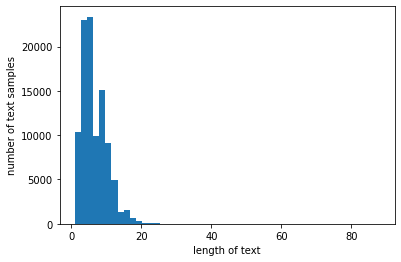

In [ ]:
print("문장 최대 길이:", max(len(text) for text in encoder_input))
print("문장 평균 길이:", sum(map(len,encoder_input))/len(encoder_input))
plt.hist([len(text) for text in encoder_input],bins = 50)
plt.xlabel("length of text")
plt.ylabel("number of text samples")
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for text in nested_list:
    if len(text) <= max_len:
      count += 1
  print("전체 샘플의 길이가 {} 이하인 샘플의 비율: {}".format(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 25
below_threshold_len(max_len, encoder_input)
below_threshold_len(max_len, decoder_input)
below_threshold_len(max_len, decoder_output)

전체 샘플의 길이가 25 이하인 샘플의 비율: 99.926
전체 샘플의 길이가 25 이하인 샘플의 비율: 99.90599999999999
전체 샘플의 길이가 25 이하인 샘플의 비율: 99.90599999999999


In [ ]:
encoder_input = pad_sequences(encoder_input,padding="post",maxlen = max_len)
decoder_input = pad_sequences(decoder_input, padding = "post", maxlen = max_len)
decoder_target = pad_sequences(decoder_output,padding="post", maxlen = max_len)

In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (100000, 25)
디코더의 입력의 크기(shape) : (100000, 25)
디코더의 레이블의 크기(shape) : (100000, 25)


In [ ]:
src_vocab_size = len(tokenizer_src.word_index) + 1
tar_vocab_size = len(tokenizer_tar.word_index) + 1
print("표준어 단어 집합의 크기 : {:d}, 제주방언 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

표준어 단어 집합의 크기 : 128836, 제주방언 단어 집합의 크기 : 104924


In [ ]:
# 단어->정수 & 정수->단어 딕셔너리
src_to_index = tokenizer_src.word_index
index_to_src = tokenizer_src.index_word
tar_to_index = tokenizer_tar.word_index
index_to_tar = tokenizer_tar.index_word

In [ ]:
# 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [40856 68477 88008 ... 20396 95482 45496]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### 훈련데이터와 테스트 데이터 분리

In [ ]:
encoder_input_train = encoder_input[:80000]
decoder_input_train = decoder_input[:80000]
decoder_target_train = decoder_target[:80000]

encoder_input_test = encoder_input[80000:]
decoder_input_test = decoder_input[80000:]
decoder_target_test = decoder_target[80000:]

### 모델 설계하기

In [2]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [ ]:
embedding_dim = 64
hidden_units = 64

In [ ]:
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta = 0, patience = 10, mode = "auto")
hist = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=200, epochs=70,callbacks=[early_stopping])

Epoch 1/70
400/400 [==============================] - 495s 1s/step - loss: 3.8164 - acc: 0.7055 - val_loss: 2.4416 - val_acc: 0.7391
Epoch 2/70
400/400 [==============================] - 488s 1s/step - loss: 2.3774 - acc: 0.7388 - val_loss: 2.4062 - val_acc: 0.7392
Epoch 3/70
400/400 [==============================] - 490s 1s/step - loss: 2.3267 - acc: 0.7403 - val_loss: 2.3981 - val_acc: 0.7411
Epoch 4/70
400/400 [==============================] - 488s 1s/step - loss: 2.2898 - acc: 0.7409 - val_loss: 2.3952 - val_acc: 0.7409
Epoch 5/70
400/400 [==============================] - 492s 1s/step - loss: 2.2499 - acc: 0.7425 - val_loss: 2.3319 - val_acc: 0.7448
Epoch 6/70
400/400 [==============================] - 495s 1s/step - loss: 2.1629 - acc: 0.7463 - val_loss: 2.2610 - val_acc: 0.7473
Epoch 7/70
400/400 [==============================] - 491s 1s/step - loss: 2.0895 - acc: 0.7491 - val_loss: 2.2259 - val_acc: 0.7498
Epoch 8/70
400/400 [==============================] - 490s 1s/step - 

In [ ]:
# 모델 저장하기
from keras.models import load_model
model.save("jeju_model_jeju2standard.h5")

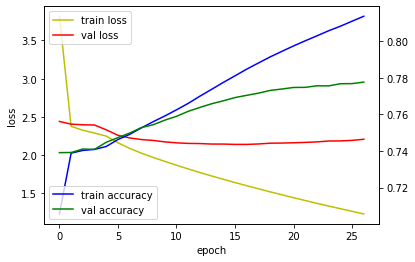

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(hist.history['acc'], 'b', label = 'train accuracy')
acc_ax.plot(hist.history['val_acc'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('acc')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

In [10]:
# 모델 불러오기
from IPython.display import SVG
import tensorflow
model = tensorflow.keras.models.load_model("jeju_model_jeju2standard.h5")


OSError: ignored

NameError: ignored